```
Multimodal sentiment detection dataset.

the files are here: https://www.dropbox.com/s/hpkdyuui5adqsek/multimodal_sentiment_dataset.zip?dl=0
the dataset comes from this paper: https://arxiv.org/abs/1708.02099
There are four classes ['creepy', 'gore', 'happy', 'rage'} (it'd be good if you could maintain this order as well)
The dropbox also contains the train, val, and test split. The images are in the subdirectory called images , and are indexed as per the id in the .pkl files. For instance if an example has id <n>, the corresponding image would be ./images/<n>.jpg/png/jpeg (the file format may vary for some of the images)
We are reporting the macro F1, precision, recall (and accuracy) – just like we did for the crisis dataset

Multimodal fakenews detection dataset.
 
the files are here: https://www.dropbox.com/s/esnr2ltp0z2ibq8/multmodal_fakenews_dataset.zip?dl=0
the dataset comes from this paper: https://ojs.aaai.org/index.php/AAAI/article/view/7230
There are two classes: 0 (not fake) and 1 (fake). Since this is binary classification task, we don't need to report macro-averaged scores. We can report the F1, precision and recall for the target class (i.e., 1/fake). In sklearn it can be specified by specifying average = 'binary' .
The dropbox contains the images as well as the .pkl files for train and test set. There's no validation set, but I used 10% randomly sampled examples from the train set as my validation set. Also, please use the image_filename str (5vthXfxXiBvcdhZRirjpnhDJJi14UqtR in the following example)  as the id for any given example.
{'title': "Teen Mom Star Jenelle Evans' Wedding Dress Is Available Here for $2999", 'image': '5vthXfxXiBvcdhZRirjpnhDJJi14UqtR.jpg', 'label': 0}
```

In [87]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import csv
import math
import pickle
import stanza
import cv2
import copy
import seaborn as sns
import time

from glob import glob
from PIL import Image
from sklearn import metrics

from os.path import basename, join
from shutil import copyfile

from torch.utils.data.sampler import BatchSampler, RandomSampler, Sampler, \
    SequentialSampler, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.nn import functional
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, \
    precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict, Counter
from json import load, dump
from torchvision import datasets, models, transforms

In [90]:
train_data = pickle.load(open('./data/fake-news-data/train_examples.pkl', 'rb'))
test_data = pickle.load(open('./data/fake-news-data/test_examples.pkl', 'rb'))

val_indexes = np.random.choice(range(len(train_data)),
                               int(len(train_data) * 0.1),
                               replace=False)
train_indexes = list(set(range(len(train_data))).difference(set(val_indexes.tolist())))

val_data = np.array(train_data)[val_indexes]
train_data = np.array(train_data)[train_indexes]

train_data_pairs = [[d['image'], - d['label'] + 1] for d in train_data]
val_data_pairs = [[d['image'], - d['label'] + 1] for d in val_data]
test_data_pairs = [[d['image'], - d['label'] + 1] for d in test_data]

In [91]:
# for f in tqdm(glob('./data/fake-news-data/AAAI_dataset/Images/*/*')):
#     name = basename(f)
#     copyfile(f, './data/fake-news-data/images/{}'.format(name))

In [92]:
Counter([i[1] for i in train_data_pairs])

Counter({0: 7492, 1: 2010})

In [93]:
class ImageDataset(Dataset):

    def __init__(self, data_pairs, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.data_pairs = data_pairs
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_pairs[idx][0])
        
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = self.data_pairs[idx][1]
        
        return image, label

In [94]:
train_dataset = ImageDataset(train_data_pairs, './data/fake-news-data/images')
val_dataset = ImageDataset(val_data_pairs, './data/fake-news-data/images')
test_dataset = ImageDataset(test_data_pairs, './data/fake-news-data/images')

batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
val_dataset_loader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [44]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, torch.max(inputs), labels)
    break

torch.Size([32, 3, 224, 224]) tensor(2.6400) tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1])


In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=20):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [46]:
num_classes = 2
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [48]:
# dataloaders = {'train': train_dataset_loader,
#                'val': val_dataset_loader}

# model, val_acc_history = train_model(model, dataloaders, criterion,
#                                      optimizer_ft, num_epochs=50,
#                                      patience=10)

# torch.save(model.state_dict(), './output/best_weights_fake.pk')
# # dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

## Analysis

In [88]:
model = models.vgg16(pretrained=True)

num_classes = 2

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_fake.pk'))
criterion = nn.CrossEntropyLoss()

In [95]:
predictions = []
true_labels = []
device = torch.device('cpu')

for inputs, labels in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    
    predictions.extend(preds.cpu().numpy().tolist())
    true_labels.extend(labels.cpu().numpy().tolist())



 25%|██▌       | 21/84 [00:39<01:45,  1.67s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 43%|████▎     | 36/84 [01:07<01:25,  1.79s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 84/84 [02:30<00:00,  1.79s/it]


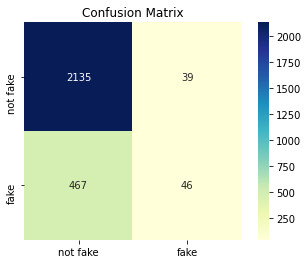

In [96]:
import seaborn as sns;

confusion = metrics.confusion_matrix(true_labels, predictions)

ticks = ['not fake', 'fake']

plt.title('Confusion Matrix')
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", square=True,
                 xticklabels=ticks, yticklabels=ticks)

In [97]:
print(
    metrics.accuracy_score(true_labels, predictions),
    metrics.f1_score(true_labels, predictions, average='binary'),
    metrics.precision_score(true_labels, predictions, average='binary'),
    metrics.recall_score(true_labels, predictions, average='binary'),
)

0.8116858950502419 0.15384615384615385 0.5411764705882353 0.08966861598440545


In [98]:
train_data = pickle.load(open('./data/fake-news-data/train_examples.pkl', 'rb'))
test_data = pickle.load(open('./data/fake-news-data/test_examples.pkl', 'rb'))

# val_indexes = np.random.choice(range(len(train_data)),
#                                int(len(train_data) * 0.1),
#                                replace=False)
# train_indexes = list(set(range(len(train_data))).difference(set(val_indexes.tolist())))

# val_data = np.array(train_data)[val_indexes]
# train_data = np.array(train_data)[train_indexes]

train_data_pairs = [[d['image'], 1 - d['label']] for d in train_data]
# val_data_pairs = [[d['image'], d['label']] for d in val_data]
test_data_pairs = [[d['image'], 1 - d['label']] for d in test_data]

In [99]:
train_data[0]

{'title': 'Kylie Jenner refusing to discuss Tyga on Life of Kylie',
 'image': '4muaHBEpDomEuc353G1ROLrfA5RbkmaI.jpg',
 'label': 1}

In [100]:
class ImageDataset(Dataset):

    def __init__(self, data_pairs, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.data_pairs = data_pairs
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_pairs[idx][0])
        
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = self.data_pairs[idx][1]
        
        # Get the id
        image_id = self.data_pairs[idx][0].replace('.jpg', '')
        
        return image, label, image_id

In [101]:
train_dataset = ImageDataset(train_data_pairs, './data/fake-news-data/images')
# val_dataset = ImageDataset(val_data_pairs, './data/images')
test_dataset = ImageDataset(test_data_pairs, './data/fake-news-data/images')

batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
# val_dataset_loader = torch.utils.data.DataLoader(val_dataset,
#                                                  batch_size=batch_size,
#                                                  shuffle=True,
#                                                  num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [102]:
model = models.vgg16(pretrained=True)
num_classes = 2

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_fake.pk'))

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs
    labels = labels
    output_256_tid.extend(list(tids))

    outputs = model(inputs)



  9%|▉         | 31/330 [00:59<08:31,  1.71s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 12%|█▏        | 38/330 [01:12<08:33,  1.76s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 17%|█▋        | 56/330 [01:43<08:06,  1.78s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 20%|█▉        | 65/330 [01:58<07:28,  1.69s/it]/nethome/zwang3049/jay/miniconda3/envs/n

In [104]:
np.savez_compressed('./data/fake-news/image_embedding_256_train.npz',
                    image_embedding=output_256,
                    image_ID=output_256_tid)

In [105]:
model = models.vgg16(pretrained=True)
num_classes = 2

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_fake.pk'))

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs
    labels = labels
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

np.savez_compressed('./data/fake-news/image_embedding_256_test.npz',
                    image_embedding=output_256,
                    image_ID=output_256_tid)

  0%|          | 0/84 [00:00<?, ?it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 51%|█████     | 43/84 [01:16<01:10,  1.73s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 60%|█████▉    | 50/84 [01:28<00:58,  1.71s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 86%|████████▌ | 72/84 [02:06<00:21,  1.76s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python

### Prob

In [107]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2))

model.load_state_dict(torch.load('./output/best_weights_fake.pk'))

<All keys matched successfully>

In [108]:
# Test set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs
    labels = labels

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

  0%|          | 0/84 [00:00<?, ?it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 14%|█▍        | 12/84 [00:21<02:03,  1.72s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 42%|████▏     | 35/84 [01:02<01:27,  1.79s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 84/84 [02:27<00:00,  1.75s/it]


In [109]:
np.savez_compressed('./data/fake-news/image_predict_probs_test.npz',
                    predict_probs=test_probs,
                    image_id=test_probs_tids)

In [110]:
# Test set

val_probs = []
val_probs_tids = []

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs
    labels = labels

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    val_probs.append(softmax_outputs)
    
    val_probs_tids.extend(list(tids))

val_probs_tids = np.vstack(val_probs_tids)

np.savez_compressed('./data/sentiment/image_predict_probs_train.npz',
                    predict_probs=val_probs,
                    image_id=val_probs_tids)

 32%|███▏      | 106/330 [03:14<07:06,  1.90s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 45%|████▍     | 147/330 [04:27<05:34,  1.83s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 55%|█████▍    | 180/330 [05:29<04:48,  1.92s/it]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 68%|██████▊   | 225/330 [06:51<03:05,  1.77s/it]/nethome/zwang3049/jay/miniconda3/en

100%|██████████| 81/81 [02:34<00:00,  1.90s/it]
/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
